In [1]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel
import sys
sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs
subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()
task = 'task-mcHERDING'

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))
plt.style.use('default')

In [2]:
def momentum_score(x):
    x = np.asarray(x)
    x_mean = np.mean(x)
    correlation_coefficients = np.corrcoef(x[1:] - x_mean, x[:-1] - x_mean)[0, 1]
    return correlation_coefficients


human_drift_scores = []
human_motion_params = []
subjects = list(subject_pool.keys())
for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                motion_params = mocet.get_motion_params(confounds_fname)[:-1,:]

                features = []
                for i in range(6):
                    features.append(np.abs(momentum_score(motion_params[:,i])))
                human_drift_scores.append(np.mean(features, axis=0))
                human_motion_params.append(motion_params)
human_drift_scores = np.array(human_drift_scores)

0.8294940429314214
0.9954992937338832


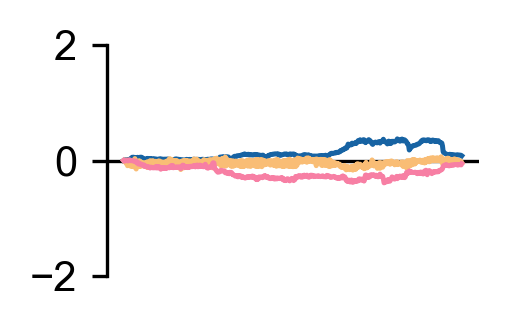

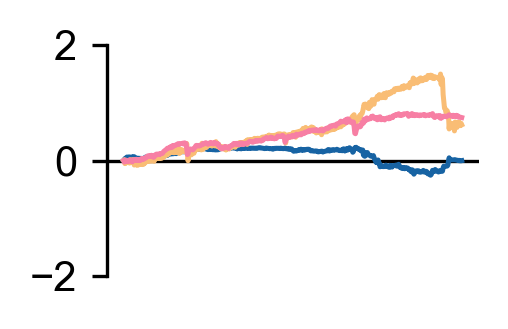

In [3]:
for idx in [0, -1]:
    top_drift_idx = np.argsort(human_drift_scores)[idx]
    print(human_drift_scores[top_drift_idx])
    motion_params = human_motion_params[top_drift_idx]
    plt.style.use('default')

    fig, ax = plt.subplots(1,1,figsize=(1.6,1.0), dpi=300, sharex=True)
    color_list = ["#1763a3","#f9bd75","#f77fa4","#1763a3","#f9bd75","#f77fa4"]
    trans_offset = 2
    for i in range(0,3):
        ax.plot(motion_params[:,i], lw=1.2, zorder=100, c=color_list[i])
        ax.set_ylim(-trans_offset, trans_offset)
        ax.set_yticks([-trans_offset,0,trans_offset])
    #
    # rot_offset = 2
    # for i in range(3,6):
    #     axes[0].plot(np.rad2deg(motion_params[:,i]), lw=1, zorder=100, c=color_list[i])
    #     axes[0].set_ylim(-rot_offset, rot_offset)
    #     axes[0].set_yticks([-rot_offset,0,rot_offset])
    #
    ax.set_xticks([])
    ax.axhline(y=0, color='k', linestyle='-', alpha=1.0, lw=0.8, zorder=0)
    ax.spines[['right', 'top','bottom']].set_visible(False)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

In [3]:
from scipy import interpolate
from numpy.polynomial.legendre import Legendre
from sklearn.linear_model import LinearRegression

calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

def make_poly_regressors(n_samples, order=2):
    X = np.ones((n_samples, 1))
    for d in range(order):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    return X

def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data

In [12]:
from scipy.stats import zscore

human_validation_errors = {}
correction_types = ['mocet', 'mocet_large', 'mocet_nonlinear', 'polynomial', 'uncorrected']
#data_types = ['drift', 'spiky', 'combined']
for correction_type in correction_types:
    human_validation_errors[correction_type] = []

drift_scores = zscore(human_drift_scores)
for correction_type in correction_types:
    k = 0
    for subject in subjects:
        print(correction_type, subject)
        sessions = subject_pool[subject].keys()
        for session in sessions:
            runs = subject_pool[subject][session]
            root = f'{project_dir}/data/eyetracking/{subject}/{session}'
            for r in runs:
                run = f'run-{r}'
                np.random.seed(0)
                key = (subject, session, task, run)
                if key in valid_data.keys():
                    log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                    data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                    confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                    history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                    start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                    drift_score = drift_scores[k]
                    k += 1

                    if correction_type == 'mocet':
                        pupil_data, pupil_timestamps, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                             data_fname,
                                                                                                             start=start,
                                                                                                             duration=task_duration)
                        pupil_data = mocet.apply_mocet(pupil_data=pupil_data,
                                                       motion_params_fname=confounds_fname,
                                                       pupil_confidence=pupil_confidence,
                                                       polynomial_order=3)
                    elif correction_type == 'mocet_large':
                        pupil_data, pupil_timestamps, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                             data_fname,
                                                                                                             start=start,
                                                                                                             duration=task_duration)
                        pupil_data = mocet.apply_mocet(pupil_data=pupil_data,
                                                       motion_params_fname=confounds_fname,
                                                       pupil_confidence=pupil_confidence,
                                                       large_motion_params=True,
                                                       polynomial_order=3)
                    elif correction_type == 'mocet_nonlinear':
                        pupil_data, pupil_timestamps, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                             data_fname,
                                                                                                             start=start,
                                                                                                             duration=task_duration)
                        pupil_data = mocet.apply_mocet(pupil_data=pupil_data,
                                                       motion_params_fname=confounds_fname,
                                                       pupil_confidence=pupil_confidence,
                                                       interactions=True,
                                                       polynomial_order=3)
                    elif correction_type == 'polynomial':
                        pupil_data, pupil_timestamps, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                             data_fname,
                                                                                                             start=start,
                                                                                                             duration=task_duration)
                        pupil_data = polynomial_detrending(pupil_data, polynomial_order=3)
                    elif correction_type == 'uncorrected':
                        pupil_data, pupil_timestamps, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                             data_fname,
                                                                                                             start=start,
                                                                                                             duration=task_duration)

                    t_cal = 0
                    t_val = 1

                    offset = calibration_onsets[t_cal]
                    calibration_pupils = []
                    for i in np.arange(calibration_points[t_cal]):
                        start = (offset + i) * interval + calibration_offset_start
                        end = (offset + i + 1) * interval + calibration_offset_end
                        log_effective = np.logical_and(pupil_timestamps >= start * 1000, pupil_timestamps < end * 1000)
                        calibration_pupils.append([np.nanmean(pupil_data[log_effective, 0]),
                                                   np.nanmean(pupil_data[log_effective, 1])])
                    calibration_pupils = np.array(calibration_pupils)

                    repeat = True if calibration_points[t_cal] == 24 else False
                    calibrator = mocet.EyetrackingCalibration(calibration_coordinates=calibration_coordinates,
                                                              calibration_order=calibration_order,
                                                              repeat=repeat)
                    calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                    gaze_coordinates = calibrator.transform(pupil_data)

                    t = 1  # for validation
                    MSE = []
                    offset = calibration_onsets[t]
                    for i in np.arange(calibration_points[t]):
                        ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                        ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                        start = (offset + i) * interval + calibration_offset_start
                        end = (offset + i + 1) * interval + calibration_offset_end
                        gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                        gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                        eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                        if np.any(~eye_closed):
                            data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                            data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                            MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                    validation_error = np.nanmean(MSE) / px_per_deg
                    human_validation_errors[correction_type].append(validation_error)

import pickle

with open('human_validation_errors.pkl', 'wb') as f:
    pickle.dump(human_validation_errors, f)

mocet sub-003
mocet sub-004
mocet sub-005
mocet sub-006
mocet sub-008
mocet sub-009
mocet sub-010
mocet sub-011
mocet sub-015
mocet sub-016
mocet sub-018
mocet sub-019
mocet sub-020
mocet sub-021
mocet sub-022
mocet sub-023
mocet sub-024
mocet sub-PBJ
mocet_large sub-003
mocet_large sub-004
mocet_large sub-005
mocet_large sub-006
mocet_large sub-008
mocet_large sub-009
mocet_large sub-010
mocet_large sub-011
mocet_large sub-015
mocet_large sub-016
mocet_large sub-018
mocet_large sub-019
mocet_large sub-020
mocet_large sub-021
mocet_large sub-022
mocet_large sub-023
mocet_large sub-024
mocet_large sub-PBJ
mocet_nonlinear sub-003
mocet_nonlinear sub-004
mocet_nonlinear sub-005
mocet_nonlinear sub-006
mocet_nonlinear sub-008
mocet_nonlinear sub-009
mocet_nonlinear sub-010
mocet_nonlinear sub-011
mocet_nonlinear sub-015
mocet_nonlinear sub-016
mocet_nonlinear sub-018
mocet_nonlinear sub-019
mocet_nonlinear sub-020
mocet_nonlinear sub-021
mocet_nonlinear sub-022
mocet_nonlinear sub-023
moce

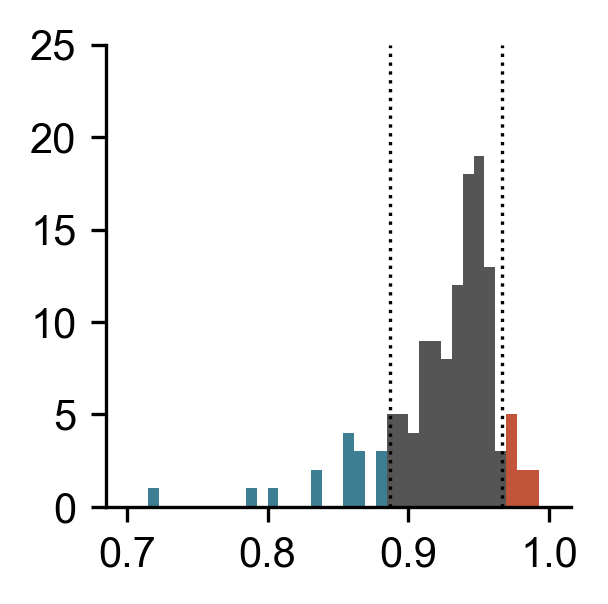

In [6]:
# Define motion types

import pickle
with open('human_validation_errors.pkl', 'rb') as f:
    human_validation_errors = pickle.load(f)

fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
bins = np.linspace(0.7,1,40)
drift_threshold = np.mean(human_drift_scores) + np.std(human_drift_scores)
spiky_threshold = np.mean(human_drift_scores) - np.std(human_drift_scores)

drift_condition = human_drift_scores>=drift_threshold
spiky_condition = human_drift_scores<=spiky_threshold
normal_condition = np.logical_and(human_drift_scores<drift_threshold,
                                  human_drift_scores>spiky_threshold)

ax.hist(human_drift_scores[drift_condition], bins=bins, color='#c25539')
ax.hist(human_drift_scores[spiky_condition], bins=bins, color='#3e7e93')
ax.hist(human_drift_scores[normal_condition], bins=bins, color='#555555')

ax.axvline(drift_threshold, c='k', linestyle=':', lw=0.8)
ax.axvline(spiky_threshold, c='k', linestyle=':', lw=0.8)
ax.set_ylim(0,25)
ax.set_xticks([0.7, 0.8, 0.9, 1.0])
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

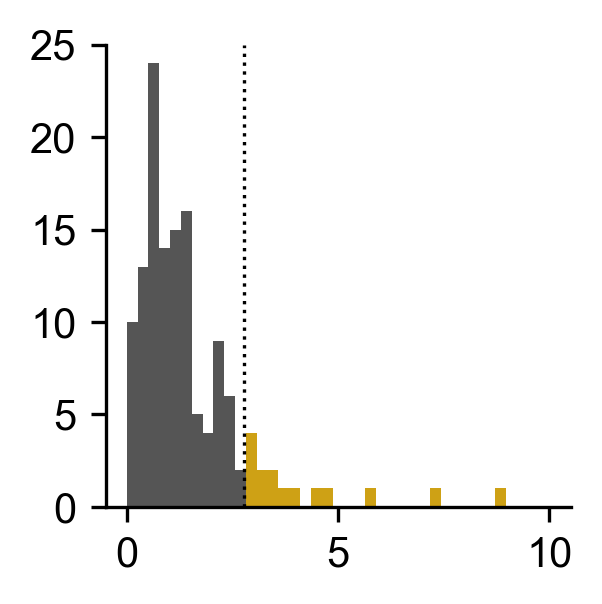

In [5]:
# Define large motion

human_displacements = []
for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                human_displacements.append(valid_data[key][3])
human_displacements = np.array(human_displacements)

fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
bins = np.linspace(0,10,40)
displacement_threshold = np.mean(human_displacements) + np.std(human_displacements)
ax.hist(human_displacements[human_displacements<displacement_threshold], bins=bins, color='#555555')
ax.hist(human_displacements[human_displacements>=displacement_threshold], bins=bins, color='#cea115')
ax.axvline(displacement_threshold, c='k', linestyle=':', lw=0.8)
ax.set_ylim(0,25)
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

('mocet', 'mocet_large')
TtestResult(statistic=np.float64(0.9872098163762946), pvalue=np.float64(0.3447573040248453), df=np.int64(11))
-------------
('mocet', 'mocet_nonlinear')
TtestResult(statistic=np.float64(0.7166417488462704), pvalue=np.float64(0.48853193676491424), df=np.int64(11))
-------------
('mocet', 'polynomial')
TtestResult(statistic=np.float64(-2.2004629624213035), pvalue=np.float64(0.050045626700029926), df=np.int64(11))
-------------


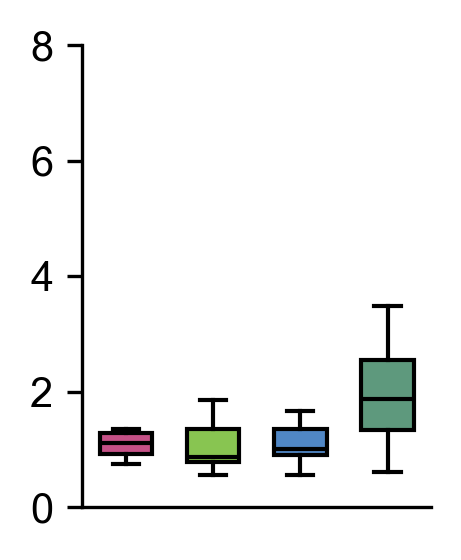

In [11]:
# Case 1: Drift
correction_types = ['mocet', 'mocet_large', 'mocet_nonlinear', 'polynomial']
condition = human_drift_scores >= drift_threshold
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2), dpi=300)
box = ax.boxplot([np.array(human_validation_errors[correction_type])[condition]
                  for correction_type in correction_types],
                 patch_artist=True,
                 showfliers=False,  # Hide outliers
                 medianprops=dict(color='black'),
                 positions=[0, 1, 2, 3],
                 widths=[0.6, 0.6, 0.6, 0.6], )

colors = ['#c55187', '#88c551', '#5087c5', '#5e997d']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

comparision_conditions = [('mocet', 'mocet_large'),
                          ('mocet', 'mocet_nonlinear'),
                          ('mocet', 'polynomial'), ]
for comparision in comparision_conditions:
    print(comparision)
    print(ttest_rel(np.array(human_validation_errors[comparision[0]])[condition],
                np.array(human_validation_errors[comparision[1]])[condition]))
    print('-------------')

ax.set_xticks([])
ax.set_ylim(0, 8)
ax.set_yticks([0, 2, 4, 6, 8])
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

('mocet', 'mocet_large')
TtestResult(statistic=np.float64(-0.656556075742949), pvalue=np.float64(0.5214123125087877), df=np.int64(15))
-------------
('mocet', 'mocet_nonlinear')
TtestResult(statistic=np.float64(-1.391659443757777), pvalue=np.float64(0.1843199415007834), df=np.int64(15))
-------------
('mocet', 'polynomial')
TtestResult(statistic=np.float64(-6.1487900856097655), pvalue=np.float64(1.862169710809072e-05), df=np.int64(15))
-------------


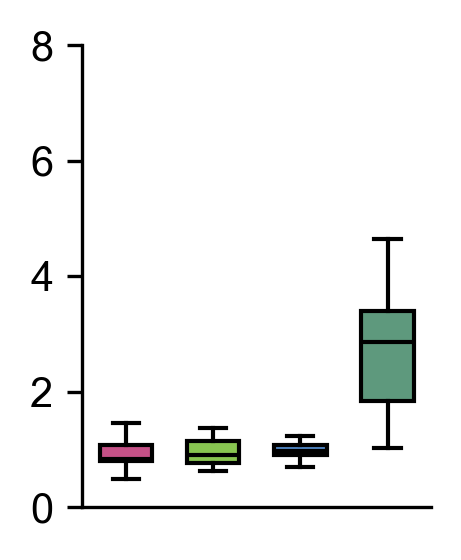

In [12]:
# Case 2: Spiky
correction_types = ['mocet', 'mocet_large', 'mocet_nonlinear', 'polynomial']
condition = human_drift_scores<=spiky_threshold
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2), dpi=300)
box = ax.boxplot([np.array(human_validation_errors[correction_type])[condition]
                  for correction_type in correction_types],
                  patch_artist=True,
                  showfliers=False,  # Hide outliers
                  medianprops=dict(color='black'),
                  positions=[0, 1, 2, 3],
                  widths=[0.6, 0.6, 0.6, 0.6], )

colors = ['#c55187', '#88c551', '#5087c5', '#5e997d']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

comparision_conditions = [('mocet', 'mocet_large'),
                          ('mocet', 'mocet_nonlinear'),
                          ('mocet', 'polynomial'), ]
for comparision in comparision_conditions:
    print(comparision)
    print(ttest_rel(np.array(human_validation_errors[comparision[0]])[condition],
                np.array(human_validation_errors[comparision[1]])[condition]))
    print('-------------')

ax.set_xticks([])
ax.set_ylim(0,8)
ax.set_yticks([0,2,4,6,8])
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

('mocet', 'mocet_large')
TtestResult(statistic=np.float64(1.5016471803308968), pvalue=np.float64(0.15540362426770846), df=np.int64(14))
-------------
('mocet', 'mocet_nonlinear')
TtestResult(statistic=np.float64(1.6154720392068582), pvalue=np.float64(0.12851258908616683), df=np.int64(14))
-------------
('mocet', 'polynomial')
TtestResult(statistic=np.float64(-4.009619286357561), pvalue=np.float64(0.0012914616930725241), df=np.int64(14))
-------------


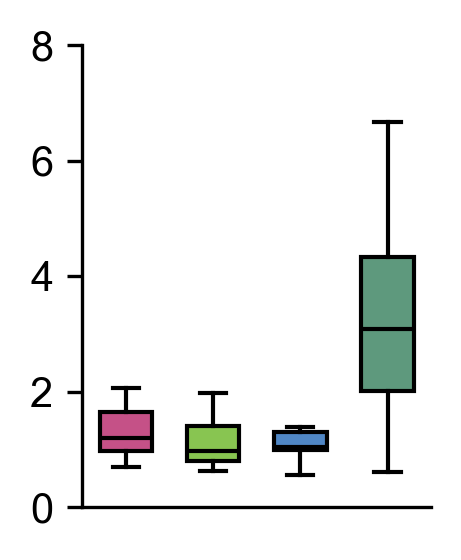

In [13]:
# Case 2: large
correction_types = ['mocet', 'mocet_large', 'mocet_nonlinear', 'polynomial']
condition = human_displacements>=displacement_threshold
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2), dpi=300)
box = ax.boxplot([np.array(human_validation_errors[correction_type])[condition]
                  for correction_type in correction_types],
                  patch_artist=True,
                  showfliers=False,  # Hide outliers
                  medianprops=dict(color='black'),
                  positions=[0, 1, 2, 3],
                  widths=[0.6, 0.6, 0.6, 0.6], )

colors = ['#c55187', '#88c551', '#5087c5', '#5e997d']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

comparision_conditions = [('mocet', 'mocet_large'),
                          ('mocet', 'mocet_nonlinear'),
                          ('mocet', 'polynomial'), ]
for comparision in comparision_conditions:
    print(comparision)
    print(ttest_rel(np.array(human_validation_errors[comparision[0]])[condition],
                np.array(human_validation_errors[comparision[1]])[condition]))
    print('-------------')

ax.set_xticks([])
ax.set_ylim(0,8)
ax.set_yticks([0,2,4,6,8])
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

('mocet', 'mocet_large')
TtestResult(statistic=np.float64(0.6588421715921412), pvalue=np.float64(0.5111447516081988), df=np.int64(132))
-------------
('mocet', 'mocet_nonlinear')
TtestResult(statistic=np.float64(1.7506922072582611), pvalue=np.float64(0.08232215681766733), df=np.int64(132))
-------------
('mocet', 'polynomial')
TtestResult(statistic=np.float64(-11.514044009136033), pvalue=np.float64(1.1417153992306707e-21), df=np.int64(132))
-------------


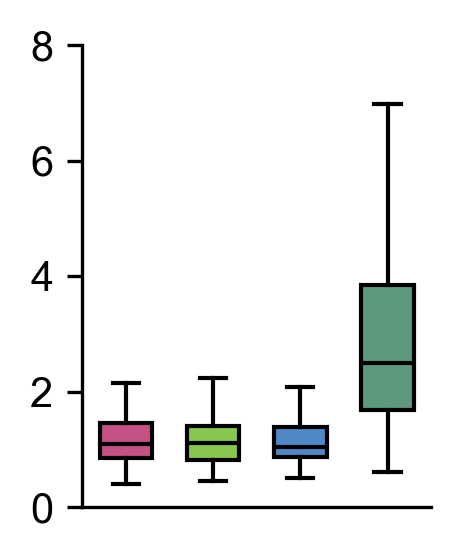

In [14]:
# Case 4: All data
# Case 2: large
correction_types = ['mocet', 'mocet_large', 'mocet_nonlinear', 'polynomial']
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2), dpi=300)
box = ax.boxplot([np.array(human_validation_errors[correction_type])
                  for correction_type in correction_types],
                  patch_artist=True,
                  showfliers=False,  # Hide outliers
                  medianprops=dict(color='black'),
                  positions=[0, 1, 2, 3],
                  widths=[0.6, 0.6, 0.6, 0.6], )

colors = ['#c55187', '#88c551', '#5087c5', '#5e997d']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

comparision_conditions = [('mocet', 'mocet_large'),
                          ('mocet', 'mocet_nonlinear'),
                          ('mocet', 'polynomial'), ]
for comparision in comparision_conditions:
    print(comparision)
    print(ttest_rel(np.array(human_validation_errors[comparision[0]]),
                np.array(human_validation_errors[comparision[1]])))
    print('-------------')

ax.set_xticks([])
ax.set_ylim(0,8)
ax.set_yticks([0,2,4,6,8])
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")